In [13]:
import pandas as pd
import numpy as np
import joblib
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, rdChemReactions

# Load everything once
model = joblib.load("mlp_classifier_model.pkl")
scaler = joblib.load("scaler.pkl")
templates_df = pd.read_csv("/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/combined_data.csv", sep='\t')

# --- Function to convert SMILES to fingerprint ---
def smiles_to_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# --- Apply template (SMARTS) to a molecule ---
def apply_template(template_smarts, smiles_input):
    mol = Chem.MolFromSmiles(smiles_input)
    if mol is None:
        return []
    try:
        rxn = rdChemReactions.ReactionFromSmarts(template_smarts)
        products = rxn.RunReactants((mol,))
        product_smiles = [
            [Chem.MolToSmiles(p) for p in prod_set if p is not None]
            for prod_set in products
        ]
        return product_smiles
    except:
        return []

# --- Predict top-k templates with probabilities ---
def predict_topk_templates(smiles_input, topk=50):
    fp = smiles_to_fingerprint(smiles_input)
    fp_scaled = scaler.transform([fp])
    probs = model.predict_proba(fp_scaled)[0]

    topk_indices = np.argsort(probs)[::-1][:topk]
    topk_template_hashes = model.classes_[topk_indices]
    topk_probs = probs[topk_indices]

    predictions = []
    for template_hash, prob in zip(topk_template_hashes, topk_probs):
        row = templates_df[templates_df['TemplateHash'] == template_hash]
        if not row.empty:
            retro_template = row.iloc[0]['RetroTemplate']
            predictions.append((template_hash, retro_template, prob))
        else:
            predictions.append((template_hash, None, prob))
    return predictions

# --- Predict and apply top templates to generate reactants ---
def predict_possible_reactants(smiles_input, topk=50):
    topk_predictions = predict_topk_templates(smiles_input, topk=topk)
    successful_predictions = []

    for template_hash, retro_template, prob in topk_predictions:
        if not retro_template:
            continue
        reactants = apply_template(retro_template, smiles_input)
        if reactants:
            successful_predictions.append((template_hash, retro_template, prob, reactants))
    
    return successful_predictions

# --- CLI usage ---
if __name__ == "__main__":
    smiles_input = input("🧪 Enter a SMILES string of the product: ")
    try:
        results = predict_possible_reactants(smiles_input)

        if results:
            print("\n✅ Successful Predictions:")
            for idx, (template_hash, retro_template, prob, reactants) in enumerate(results, 1):
                print(f"\n🔹 Prediction {idx}")
                print(f"TemplateHash: {template_hash}")
                print(f"Model Probability: {prob*100:.2f}%")
                print(f"Template SMARTS: {retro_template}")
                print(f"Predicted Reactants:")
                for rset in reactants:
                    print(f"   {rset}")
        else:
            print("❗ No valid templates generated any reactants.")
    except Exception as e:
        print(f"❌ Error: {e}")


[18:43:56] DEPRECATION WARNING: please use MorganGenerator


KeyboardInterrupt: 

In [ ]:
#Test molecules 

#Acetophenone: 
CC(=O)c1ccccc1
#Benzyl alcohol:
CC(C1=CC=CC=C1)O

In [44]:
import joblib
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdChemReactions

# Load model, scaler, label encoder, and template data
model = joblib.load("mlp_classifier_model.pkl")
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")
templates_df = pd.read_csv("/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/combined_data.csv", sep="\t")

# Convert a SMILES string to a fingerprint
def smiles_to_fingerprint(smiles, n_bits=2048, radius=2):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

# Predict top-k template hashes
def predict_topk_templates(smiles, topk=50):
    fp = smiles_to_fingerprint(smiles)
    fp_scaled = scaler.transform([fp])
    probs = model.predict_proba(fp_scaled)[0]
    topk_indices = np.argsort(probs)[::-1][:topk]
    topk_template_hashes = label_encoder.inverse_transform(model.classes_[topk_indices])
    topk_probs = probs[topk_indices]
    return list(zip(topk_template_hashes, topk_probs))

# Apply a SMARTS reaction to a molecule
def apply_template(smarts, product_smiles):
    mol = Chem.MolFromSmiles(product_smiles)
    try:
        rxn = rdChemReactions.ReactionFromSmarts(smarts)
        results = rxn.RunReactants((mol,))
        return [[Chem.MolToSmiles(m) for m in rset] for rset in results]
    except:
        return []

# --- Main ---
if __name__ == "__main__":
    smiles_input = "C1C=CC=C(C(C)=O)C=1"

    topk_predictions = predict_topk_templates(smiles_input, topk=50)

    print("\n📋 Top 50 Predicted Templates & Reactants:")
    for rank, (template_hash, prob) in enumerate(topk_predictions, 1):
        row = templates_df[templates_df['TemplateHash'] == template_hash]
        if not row.empty:
            template_smarts = row.iloc[0]['RetroTemplate']
            reactants_sets = apply_template(template_smarts, smiles_input)

            print(f"\n🔹 Rank {rank}")
            print(f"TemplateHash: {template_hash}")
            print(f"Model Probability: {prob * 100:.2f}%")
            print(f"SMARTS: {template_smarts}")

            if reactants_sets:
                print("Predicted Reactants:")
                for rset in reactants_sets:
                    print(f"   {rset}")
            else:
                print("❗ No valid reactants generated.")
        else:
            print(f"\n🔹 Rank {rank}")
            print(f"TemplateHash: {template_hash}")
            print(f"Model Probability: {prob * 100:.2f}%")
            print("SMARTS: ❓ Not found")




📋 Top 50 Predicted Templates & Reactants:

🔹 Rank 1
TemplateHash: 48f10ff74d169fa0e178f35a1ce3c47c44293cbf10a0217ec438b38bd488225f
Model Probability: 17.17%
SMARTS: [C;D1;H3:2]-[C;H0;D3;+0:1](-[c:3])=[C;H0;D3;+0:9](-[C:10]#[N;D1;H0:11])-[C:7](=[O;D1;H0:8])-[#8:6]-[C:5]-[C;D1;H3:4]>>O=[C;H0;D3;+0:1](-[C;D1;H3:2])-[c:3].[C;D1;H3:4]-[C:5]-[#8:6]-[C:7](=[O;D1;H0:8])-[CH2;D2;+0:9]-[C:10]#[N;D1;H0:11]
❗ No valid reactants generated.

🔹 Rank 2
TemplateHash: 5c7b0b8db719feb0df1a35369dbb771181e478f316af2cbea6b5489f81a3bfe9
Model Probability: 10.19%
SMARTS: [C:2]-[C;H0;D4;+0:1](-[C:3])(-[C:4])-[c;H0;D3;+0:6](:[c:5]):[c:7]>>Br-[C;H0;D4;+0:1](-[C:2])(-[C:3])-[C:4].[c:5]:[cH;D2;+0:6]:[c:7]
❗ No valid reactants generated.

🔹 Rank 3
TemplateHash: 90c5ad7cf542d2b9ef0a1086bb9a46edb1bf4288c5e2fb5127ed997a5b2ba936
Model Probability: 7.71%
SMARTS: [C:2]-[C;H0;D3;+0:1](-[c:3])=[N;H0;D2;+0:4]-[c:5]>>O=[C;H0;D3;+0:1](-[C:2])-[c:3].[NH2;D1;+0:4]-[c:5]
❗ No valid reactants generated.

🔹 Rank 4
TemplateHash: c

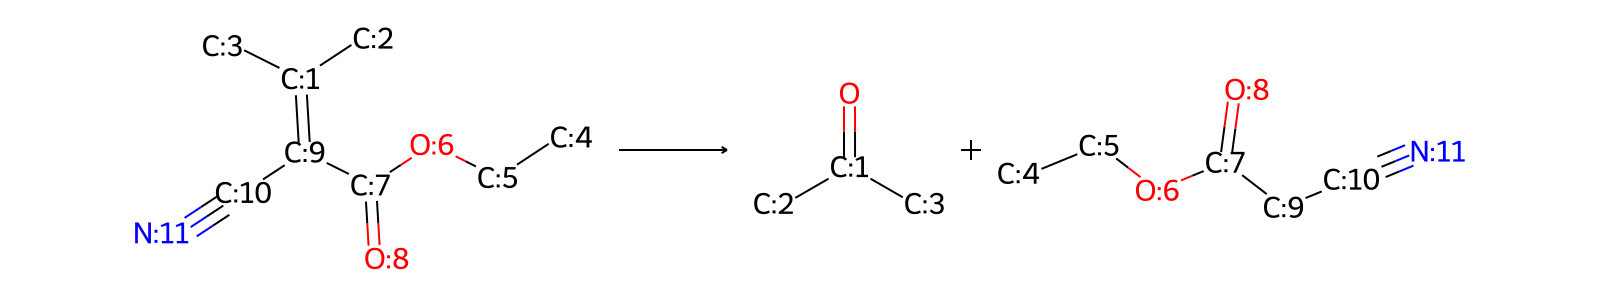

In [46]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from IPython.display import display

# Define the SMARTS reaction
smarts = "[C;D1;H3:2]-[C;H0;D3;+0:1](-[c:3])=[C;H0;D3;+0:9](-[C:10]#[N;D1;H0:11])-[C:7](=[O;D1;H0:8])-[#8:6]-[C:5]-[C;D1;H3:4]>>O=[C;H0;D3;+0:1](-[C;D1;H3:2])-[c:3].[C;D1;H3:4]-[C:5]-[#8:6]-[C:7](=[O;D1;H0:8])-[CH2;D2;+0:9]-[C:10]#[N;D1;H0:11]"

# Create RDKit reaction object
reaction = rdChemReactions.ReactionFromSmarts(smarts)

# Draw the reaction and display
img = Draw.ReactionToImage(reaction, subImgSize=(400, 300))
display(img)




